In [8]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/home/yoran/sample/gan/mnist')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /home/yoran/sample/gan/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /home/yoran/sample/gan/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /home/yoran/sample/gan/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /home/yoran/sample/gan/mnist/t10k-labels-idx1-ubyte.gz


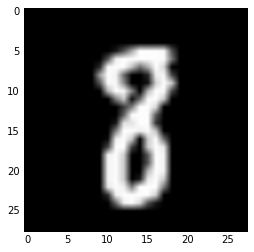

In [11]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28,28)),cmap='Greys_r')

In [12]:
#construct model
## inputs
## generator
## discriminator
## loss&&optimizer

def get_inputs(real_size,noise_size):
    '''
    real image tensor and noise image tensor
    '''
    
    real_img = tf.placeholder(tf.float32,[None,real_size],name='real_img')
    noise_img = tf.placeholder(tf.float32,[None,noise_size],name='noise_img')
    
    return real_img,noise_img

In [21]:
## generator
def get_generator(noise_img,n_units,out_dim,reuse=False,alpha=0.01):
    '''
    generator
    
    noise_img: the input of the generator
    n_units: the number of hidden units
    out_dim: the size of the output tensor, specially it should be 32*32=784 here
    alpha: the coefficient of the leaky relu
    '''
    
    with tf.variable_scope('generator',reuse=reuse):
        #hidden layer
        hidden1 = tf.layers.dense(noise_img,n_units)
        #leaky relu
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        #dropout
        hidden1 = tf.layers.dropout(hidden1,rate=0.2)
        
        #logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits,outputs        

In [25]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    discriminator 
    
    n_units: the number of hidden layer
    alpha: Leaky ReLU's coefficient
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

In [19]:
# define parameters
# the size of real img
img_size = mnist.train.images[0].shape[0]
# the size of the noise which will be transfered to the generator
noise_size = 100
# the number of hidden units which belongs to the generator
g_units = 128
# the number of hidden units which belongs to the discriminator
d_units = 128
# leaky relu's parameter
alpha = 0.01
# learning rate
learning_rate = 0.001
#label smoothing
smooth = 0.1 # the parameter of the label smoothing regularization

In [26]:
#construct the network
tf.reset_default_graph()

real_img,noise_img = get_inputs(img_size,noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img,g_units,img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img,d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs,d_units,reuse=True)

In [27]:
## Loss
'''
这里简单说一下Loss的计算方式，由于我们上面构建了两个神经网络：generator和discriminator，因此需要分别计算loss。
discriminator discriminator的目的在于对于给定的真图片，识别为真（1），对于generator生成的图片，识别为假（0），因此它的loss包含了真实图片的loss和生成器图片的loss两部分。
generator generator的目的在于让discriminator识别不出它的图片是假的，如果用1代表真，0代表假，那么generator生成的图片经过discriminator后要输出为1，因为generator想要骗过discriminator。
'''
# discriminator's loss
# recognize the real image
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# recognize the fake image
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))

# total loss of discriminator
d_loss = tf.add(d_loss_real,d_loss_fake)

#generator's loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

In [29]:
#optimizer
#由于我们在GAN里面一共训练了两个网络，所以需要分别定义优化函数。

train_vars = tf.trainable_variables()

#generator's tensor
g_vars = [var for var in train_vars if var.name.startswith('generator')]
#discriminator's tensor
d_vars = [var for var in train_vars if var.name.startswith('discriminator')]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss,var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss,var_list=g_vars)

In [31]:
## train
#batch size
batch_size = 64
# epoches
epoches = 300
# the number of examples sampled
n_sample = 25

#  save the test examples
samples = []
# save the loss
losses = []
# save the generator's variables
saver = tf.train.Saver(var_list=g_vars)
# start train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epoches):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size,784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator's input (noise)
            batch_noise = np.random.uniform(-1,1,size=(batch_size, noise_size))
            
            # run optimizers
            _ = sess.run(d_train_opt,feed_dict={real_img:batch_images,noise_img:batch_noise})
            _ = sess.run(g_train_opt,feed_dict={noise_img:batch_noise})
        
        #calculate the loss every epoch completed
        train_loss_d = sess.run(d_loss,feed_dict={real_img: batch_images, 
                                             noise_img: batch_noise})
        # real image loss
        train_loss_d_real = sess.run(d_loss_real,feed_dict={real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake,feed_dict={real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss,feed_dict={noise_img: batch_noise})
        
        print("Epoch {}/{}...".format(e+1, epoches),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))
        
        # save all kinds of loss
        losses.append((train_loss_d,train_loss_d_real,train_loss_d_fake,train_loss_g))
        
        sample_noise = np.random.uniform(-1,1,size=(n_sample,noise_size))
        gen_samples = sess.run(get_generator(noise_img,g_units,img_size,reuse=True),
                              feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        saver.save(sess,'./checkpoints/generator.ckpt')
    
    with open('train_sample.pkl','wb') as f:
        pickle.dump(samples,f)

Epoch 1/300... Discriminator Loss: 0.0313(Real: 0.0044 + Fake: 0.0269)... Generator Loss: 3.4774
Epoch 2/300... Discriminator Loss: 0.2844(Real: 0.1425 + Fake: 0.1419)... Generator Loss: 2.3278
Epoch 3/300... Discriminator Loss: 2.3947(Real: 1.1665 + Fake: 1.2281)... Generator Loss: 7.1273
Epoch 4/300... Discriminator Loss: 1.8999(Real: 0.9020 + Fake: 0.9979)... Generator Loss: 1.0003
Epoch 5/300... Discriminator Loss: 1.8573(Real: 0.9257 + Fake: 0.9316)... Generator Loss: 1.9336
Epoch 6/300... Discriminator Loss: 1.6426(Real: 1.0264 + Fake: 0.6162)... Generator Loss: 2.3210
Epoch 7/300... Discriminator Loss: 0.9901(Real: 0.6311 + Fake: 0.3590)... Generator Loss: 2.2380
Epoch 8/300... Discriminator Loss: 2.6560(Real: 1.5524 + Fake: 1.1036)... Generator Loss: 1.1550
Epoch 9/300... Discriminator Loss: 1.2071(Real: 0.8377 + Fake: 0.3694)... Generator Loss: 2.1423
Epoch 10/300... Discriminator Loss: 2.5804(Real: 1.2629 + Fake: 1.3175)... Generator Loss: 1.8872
Epoch 11/300... Discriminator

Epoch 85/300... Discriminator Loss: 0.9755(Real: 0.5550 + Fake: 0.4205)... Generator Loss: 1.3030
Epoch 86/300... Discriminator Loss: 1.1109(Real: 0.4900 + Fake: 0.6210)... Generator Loss: 1.2245
Epoch 87/300... Discriminator Loss: 1.0236(Real: 0.4299 + Fake: 0.5937)... Generator Loss: 1.1635
Epoch 88/300... Discriminator Loss: 1.0292(Real: 0.4282 + Fake: 0.6010)... Generator Loss: 1.1602
Epoch 89/300... Discriminator Loss: 0.8212(Real: 0.4149 + Fake: 0.4063)... Generator Loss: 1.3623
Epoch 90/300... Discriminator Loss: 1.2379(Real: 0.8247 + Fake: 0.4133)... Generator Loss: 1.5506
Epoch 91/300... Discriminator Loss: 1.1741(Real: 0.5824 + Fake: 0.5917)... Generator Loss: 1.0601
Epoch 92/300... Discriminator Loss: 0.7083(Real: 0.3740 + Fake: 0.3343)... Generator Loss: 1.5835
Epoch 93/300... Discriminator Loss: 0.8746(Real: 0.4917 + Fake: 0.3829)... Generator Loss: 1.6468
Epoch 94/300... Discriminator Loss: 0.8077(Real: 0.4876 + Fake: 0.3201)... Generator Loss: 1.5980
Epoch 95/300... Disc

Epoch 168/300... Discriminator Loss: 1.0377(Real: 0.5450 + Fake: 0.4927)... Generator Loss: 1.4487
Epoch 169/300... Discriminator Loss: 0.9834(Real: 0.4755 + Fake: 0.5079)... Generator Loss: 1.1976
Epoch 170/300... Discriminator Loss: 1.1191(Real: 0.5486 + Fake: 0.5704)... Generator Loss: 1.2119
Epoch 171/300... Discriminator Loss: 0.9467(Real: 0.3818 + Fake: 0.5650)... Generator Loss: 1.2026
Epoch 172/300... Discriminator Loss: 0.8356(Real: 0.4886 + Fake: 0.3470)... Generator Loss: 1.6174
Epoch 173/300... Discriminator Loss: 0.9632(Real: 0.5449 + Fake: 0.4183)... Generator Loss: 1.7404
Epoch 174/300... Discriminator Loss: 0.8123(Real: 0.3690 + Fake: 0.4433)... Generator Loss: 1.4219
Epoch 175/300... Discriminator Loss: 0.9489(Real: 0.4564 + Fake: 0.4925)... Generator Loss: 1.4556
Epoch 176/300... Discriminator Loss: 1.0285(Real: 0.5648 + Fake: 0.4637)... Generator Loss: 1.4859
Epoch 177/300... Discriminator Loss: 0.9201(Real: 0.5055 + Fake: 0.4146)... Generator Loss: 1.6037
Epoch 178/

Epoch 251/300... Discriminator Loss: 0.8065(Real: 0.3833 + Fake: 0.4232)... Generator Loss: 1.4944
Epoch 252/300... Discriminator Loss: 0.9997(Real: 0.5972 + Fake: 0.4025)... Generator Loss: 1.5812
Epoch 253/300... Discriminator Loss: 0.8338(Real: 0.4489 + Fake: 0.3849)... Generator Loss: 1.6222
Epoch 254/300... Discriminator Loss: 0.9775(Real: 0.5680 + Fake: 0.4095)... Generator Loss: 1.6974
Epoch 255/300... Discriminator Loss: 0.9677(Real: 0.5419 + Fake: 0.4258)... Generator Loss: 1.5582
Epoch 256/300... Discriminator Loss: 0.7308(Real: 0.3565 + Fake: 0.3743)... Generator Loss: 1.4438
Epoch 257/300... Discriminator Loss: 0.9554(Real: 0.4765 + Fake: 0.4789)... Generator Loss: 1.4527
Epoch 258/300... Discriminator Loss: 0.6706(Real: 0.4491 + Fake: 0.2215)... Generator Loss: 2.1700
Epoch 259/300... Discriminator Loss: 0.8587(Real: 0.4248 + Fake: 0.4339)... Generator Loss: 1.6447
Epoch 260/300... Discriminator Loss: 0.8914(Real: 0.5525 + Fake: 0.3389)... Generator Loss: 1.6068
Epoch 261/

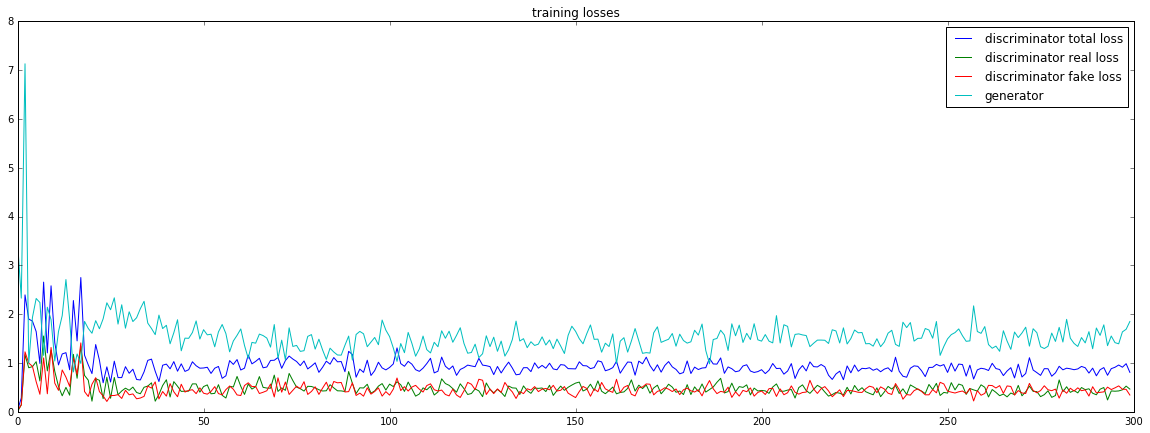

In [33]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0],label='discriminator total loss')
plt.plot(losses.T[1],label='discriminator real loss')
plt.plot(losses.T[2],label='discriminator fake loss')
plt.plot(losses.T[3],label='generator')
plt.title('training losses')
plt.legend()

In [35]:
# load samples from generator taken while training
with open('train_sample.pkl','rb') as f:
    samples = pickle.load(f)

In [38]:
def view_samples(epoch,samples):
    '''
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    '''
    fig,axes = plt.subplots(figsize=(7,7),nrows=5,ncols=5,sharey=True,sharex=True)
    for ax,img in zip(axes.flatten(),samples[epoch][1]): #这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape(28,28),cmap='Greys_r')
        
    return fig,axes

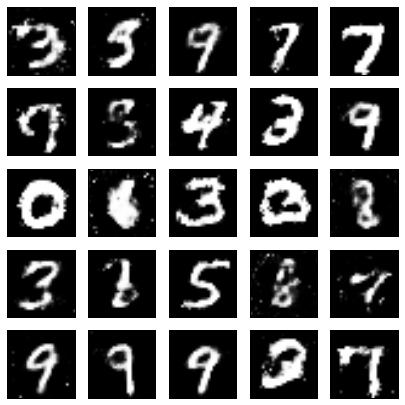

In [40]:
_ = view_samples(-1,samples) #show the outputs of the last epoch

In [41]:
# designate the epoch that we want to look up
epoch_idx = [0, 5, 10, 20, 40, 60, 80, 100, 150, 250]
show_images = []
for i in epoch_idx:
    show_images.append(samples[i][1])

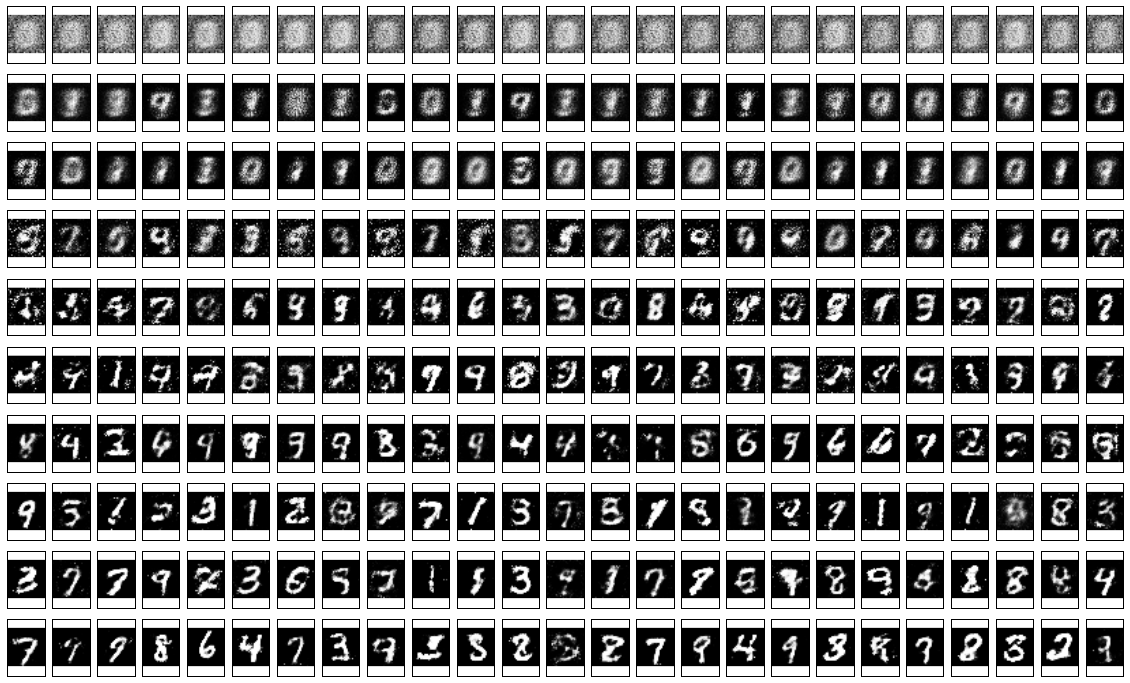

In [44]:
rows,cols = 10,25
fig, axes = plt.subplots(figsize=(20,12),nrows=rows,ncols=cols,sharex=True,sharey=True)

idx = range(0,epoches,int(epoches/rows))

for sample,ax_row in zip(show_images,axes):
    for img,ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)),cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [45]:
# generate new digits
# load checkpoints
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1,1,size=(25,noise_size))
    gen_samples = sess.run(get_generator(noise_img,g_units,img_size,reuse=True),
                          feed_dict={noise_img:sample_noise})

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


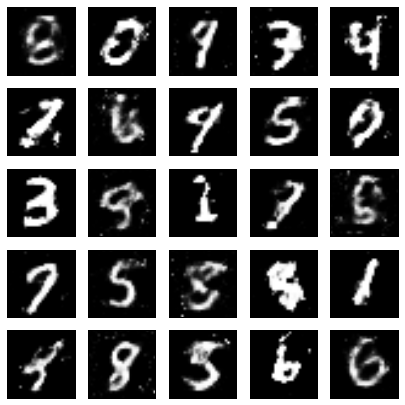

In [46]:
_ = view_samples(0,[gen_samples])